In [ ]:
import sys
!{sys.executable} -m pip install wrds

In [195]:
# Importation des librairies de base
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import argparse

# Données
import wrds

#2.1
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from sklearn.metrics import mean_squared_error

#2.2
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
import scipy.stats as stats

#2.3 
import statsmodels.api as sm

# 2.4
from dataclasses import dataclass


In [17]:
db = wrds.Connection(wrds_username='lilas_bertot')

Loading library list...
Done


# PRÉPARATION DES DONNÉES UTILISÉES

In [18]:
spx_query = """
SELECT date, spindx as prc
FROM crsp.dsi
WHERE date >= '2010-01-01'
AND spindx IS NOT NULL
ORDER BY date;
"""
spx_data = db.raw_sql(spx_query, date_cols=['date'])
spx_data = spx_data.rename(columns={'prc': 'SP500'})
spx_data['date'] = pd.to_datetime(spx_data['date'])

print(spx_data)
print("Nombre d’observations :", len(spx_data))

           date    SP500
0    2010-01-04  1132.99
1    2010-01-05  1136.52
2    2010-01-06  1137.14
3    2010-01-07  1141.69
4    2010-01-08  1144.98
...         ...      ...
3769 2024-12-24  6040.04
3770 2024-12-26  6037.59
3771 2024-12-27  5970.84
3772 2024-12-30  5906.94
3773 2024-12-31  5881.63

[3774 rows x 2 columns]
Nombre d’observations : 3774


In [19]:
# téléchargement indices boursier 3 marchés développés: DAX (Allemagne), Nikkei225 (Japon), FTSE100 (Royaume-Uni)
# téléchargement indices boursier 2 marchés émergents: Bovespa (Brésil), Nifty50 (Inde)

intern_indices_query = """
SELECT 
    datadate,
    MAX(CASE WHEN gvkeyx = '150095' THEN prccd END) AS DAX,
    MAX(CASE WHEN gvkeyx = '150008' THEN prccd END) AS FTSE100,
    MAX(CASE WHEN gvkeyx = '150069' THEN prccd END) AS Nikkei225,
    MAX(CASE WHEN gvkeyx = '150086' THEN prccd END) AS Bovespa,
    MAX(CASE WHEN gvkeyx = '151120' THEN prccd END) AS Nifty50
FROM comp.g_idx_daily
WHERE gvkeyx IN ('150095', '150008', '150069', '150086', '151120')
  AND datadate >= '2010-01-01'
  AND prccd IS NOT NULL
GROUP BY datadate
ORDER BY datadate
"""
intern_indices_data = db.raw_sql(intern_indices_query, date_cols=['datadate'])
intern_indices_data['datadate'] = pd.to_datetime(intern_indices_data['datadate'])

intern_indices_data.columns = ['datadate', 'DAX', 'FTSE100', 'Nikkei225', 'Bovespa', 'Nifty50']

print(intern_indices_data)
print("Nombre d’observations :", len(intern_indices_data))

       datadate       DAX    FTSE100  Nikkei225    Bovespa   Nifty50
0    2010-01-01   5957.43    5412.88   10546.44   68588.41   5201.05
1    2010-01-04    6048.3    5500.34   10654.79   70045.08    5232.2
2    2010-01-05   6031.86     5522.5   10681.83   70239.82    5277.9
3    2010-01-06   6034.33    5530.04   10731.45   70729.34    5281.8
4    2010-01-07   6019.36    5526.72   10681.66   70451.12    5263.1
...         ...       ...        ...        ...        ...       ...
4143 2025-11-03  24132.41  9701.3714   52411.34  150454.24  25763.35
4144 2025-11-04  23949.11  9714.9606    51497.2   150704.2   25597.7
4145 2025-11-05  24049.74   9777.085   50212.27  153294.44   25597.7
4146 2025-11-06  23734.02  9735.7842   50883.68  153338.63   25509.7
4147 2025-11-07  23569.96  9682.5741   50276.37  154063.53   25492.3

[4148 rows x 6 columns]
Nombre d’observations : 4148


In [20]:
data_dict = {
    'DAX': intern_indices_data[['DAX']],
    'FTSE100': intern_indices_data[['FTSE100']],
    'NIKKEI225': intern_indices_data[['Nikkei225']],
    'BOVESPA': intern_indices_data[['Bovespa']],
    'NIFTY50': intern_indices_data[['Nifty50']]
}

# SP500 comme base
spx_df = spx_data.set_index('date')[['SP500']]

# Fusionner sur toutes les dates communes (car différents fériés, etc.)
all_data = spx_df.copy()
for name, df in data_dict.items():
    df = df.set_index(intern_indices_data['datadate']) 
    all_data = all_data.join(df, how='inner')

common_dates = all_data.dropna().index
all_data = all_data.loc[common_dates]

print("Données fusionnées :")
print(all_data)

print("Nombre d’observations par indice après la fusion des données :")
print(all_data.count())

print("Période couverte par tous les indices :")
print(all_data.index.min().date(), "à", all_data.index.max().date())

Données fusionnées :
              SP500       DAX    FTSE100  Nikkei225    Bovespa  Nifty50
2010-01-04  1132.99    6048.3    5500.34   10654.79   70045.08   5232.2
2010-01-05  1136.52   6031.86     5522.5   10681.83   70239.82   5277.9
2010-01-06  1137.14   6034.33    5530.04   10731.45   70729.34   5281.8
2010-01-07  1141.69   6019.36    5526.72   10681.66   70451.12   5263.1
2010-01-08  1144.98   6037.61    5534.24   10798.32    70262.7  5244.75
...             ...       ...        ...        ...        ...      ...
2024-12-24  6040.04  19848.77  8136.9933   39036.85  120766.57  23727.7
2024-12-26  6037.59  19848.77  8136.9933   39568.06   121077.5  23750.2
2024-12-27  5970.84  19984.32  8149.7804   40281.16  120269.31  23813.4
2024-12-30  5906.94  19909.14  8121.0077   39894.54   120283.4  23644.9
2024-12-31  5881.63  19909.14  8173.0239   39894.54   120283.4  23644.8

[3773 rows x 6 columns]
Nombre d’observations par indice après la fusion des données :
SP500        3773
DAX      

# PARTIE 2.1

##### Étapes à suivre 
- Calcul des rendements (faire graphique pour visualiser la volatilité et "deviner" visuellement le degré de corrélation);
- Calcul des corrélations mobiles entre SP500 et autres indices internationaux (faire graphique pour interprétation visuelle);
- Établir les statistiques descriptives de chaque série de corrélation pour interprétation;
- Autocorrélation à lag 1 pour voir la persistance temporelle;
- Détecter la stationnarité de chaque série;
- Interprétation


In [21]:
# Calcul rendements journaliers 
returns = np.log(all_data / all_data.shift(1))
returns = returns.dropna(how="any")

print("Aperçu rendements :")
print(returns)

Aperçu rendements :
               SP500       DAX   FTSE100  Nikkei225   Bovespa   Nifty50
2010-01-05  0.003111 -0.002722  0.004021   0.002535  0.002776  0.008696
2010-01-06  0.000545  0.000409  0.001364   0.004635  0.006945  0.000739
2010-01-07  0.003993 -0.002484 -0.000601   -0.00465 -0.003941 -0.003547
2010-01-08  0.002878  0.003027   0.00136   0.010862 -0.002678 -0.003493
2010-01-11  0.001745  0.000479  0.000692        0.0  0.002428  0.000886
...              ...       ...       ...        ...       ...       ...
2024-12-24  0.010982       0.0  0.004221  -0.003184       0.0 -0.001085
2024-12-26 -0.000406       0.0       0.0   0.013516  0.002571  0.000948
2024-12-27 -0.011117  0.006806   0.00157   0.017862 -0.006697  0.002657
2024-12-30  -0.01076 -0.003769 -0.003537  -0.009644  0.000117 -0.007101
2024-12-31 -0.004294       0.0  0.006385        0.0       0.0 -0.000004

[3772 rows x 6 columns]


<Figure size 1200x600 with 0 Axes>

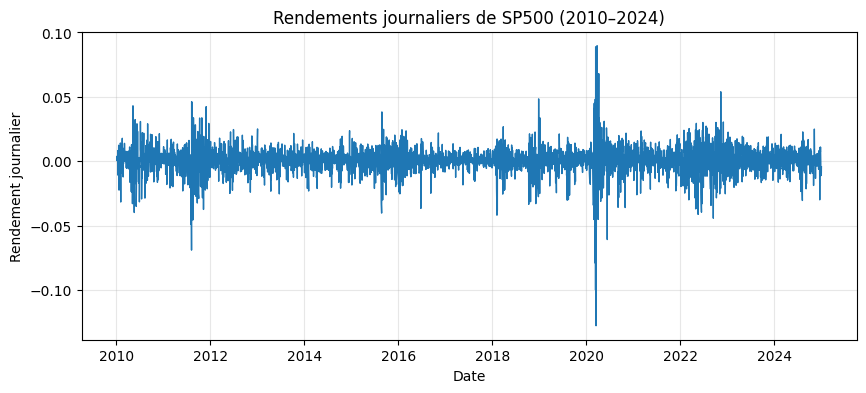

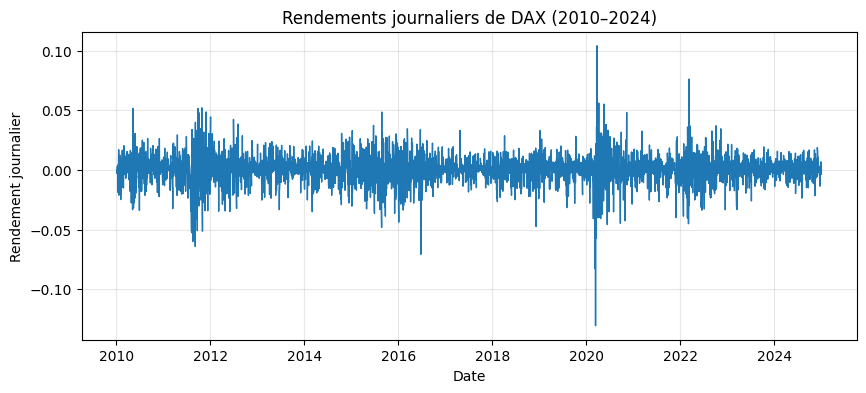

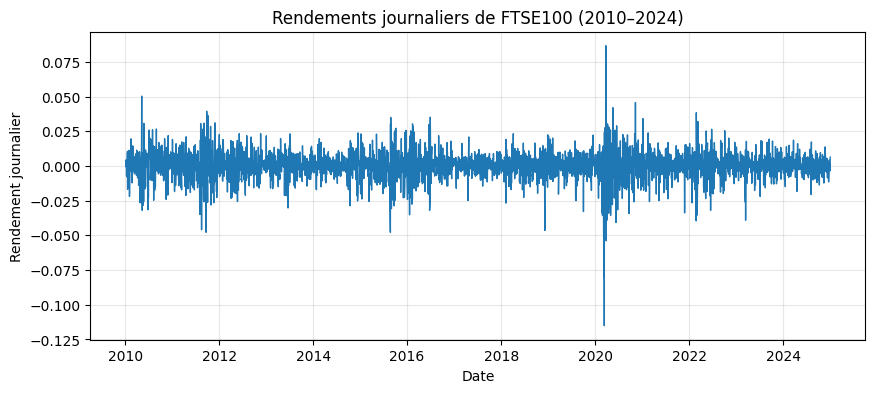

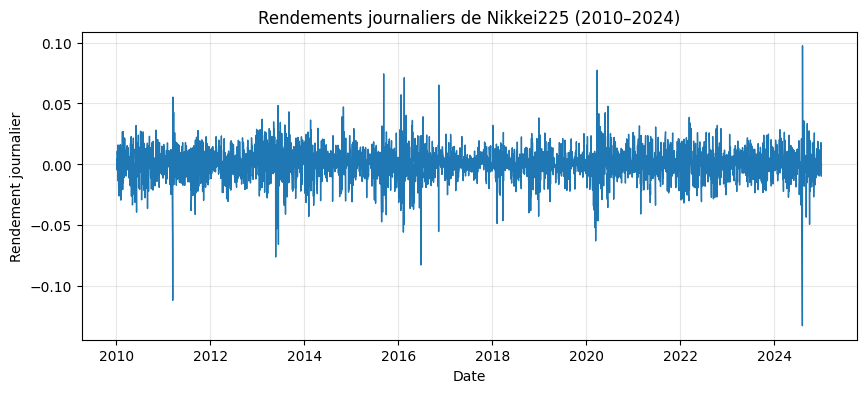

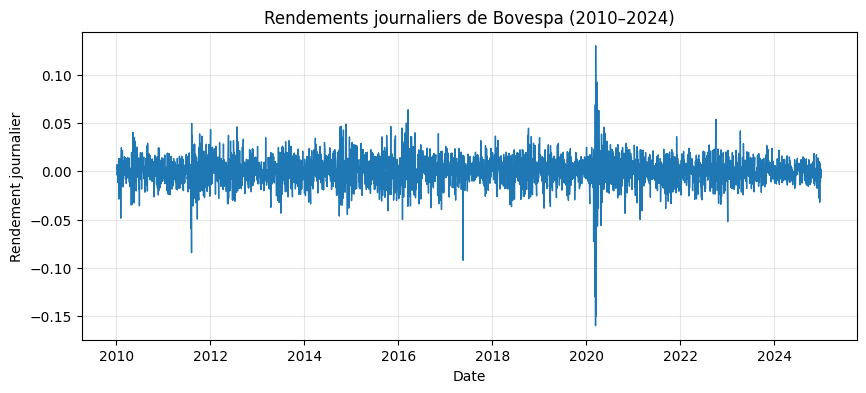

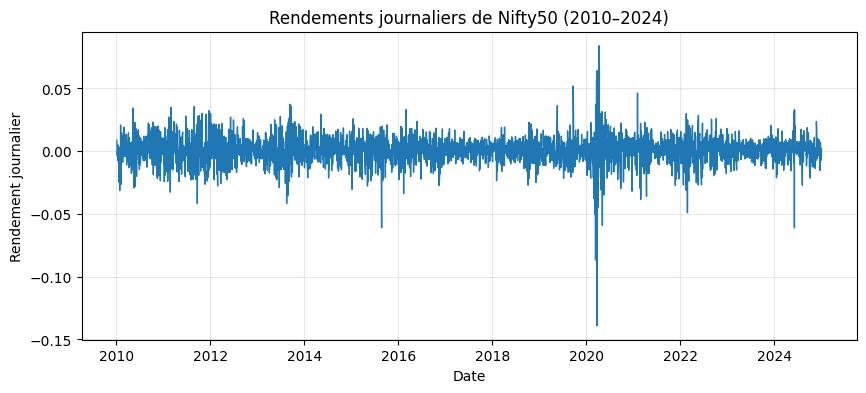

In [22]:
# Graphique des rendements journaliers
plt.figure(figsize=(12,6))
for col in returns.columns:
    plt.figure(figsize=(10, 4))
    plt.plot(returns.index, returns[col], color='tab:blue', linewidth=1)
    plt.title(f"Rendements journaliers de {col} (2010–2024)")
    plt.xlabel("Date")
    plt.ylabel("Rendement journalier")
    plt.grid(True, alpha=0.3)
    plt.show()

In [23]:
# fenêtre 126 jours comme demandé
WIN = 126 

# Corrélation mobile entre SP500 et chaque autre indice
corr_cols = ['DAX','Nikkei225','FTSE100','Bovespa','Nifty50']
corr_mob = pd.DataFrame(index=returns.index)

for col in corr_cols:
    corr_mob[f'corr_SP500_{col}'] = returns['SP500'].rolling(WIN).corr(returns[col])

corr_mob = corr_mob.dropna()

print("Corrélations mobiles (126j) :")
print(corr_mob)
print("\nNombre d'observations par série de corrélation :")
print(corr_mob.count())

Corrélations mobiles (126j) :
            corr_SP500_DAX  corr_SP500_Nikkei225  corr_SP500_FTSE100  \
2010-07-06        0.635893              0.210762            0.652437   
2010-07-07        0.633235              0.197942            0.651739   
2010-07-08        0.634284              0.206302            0.653415   
2010-07-09        0.635668              0.208772            0.654471   
2010-07-12        0.635538              0.207499            0.653911   
...                    ...                   ...                 ...   
2024-12-24        0.447845              0.369157            0.364970   
2024-12-26        0.447994              0.368094            0.366220   
2024-12-27        0.437256              0.357290            0.360101   
2024-12-30        0.439044              0.359404            0.363076   
2024-12-31        0.445482              0.357310            0.362917   

            corr_SP500_Bovespa  corr_SP500_Nifty50  
2010-07-06            0.770152            0.326947  

<Figure size 1200x600 with 0 Axes>

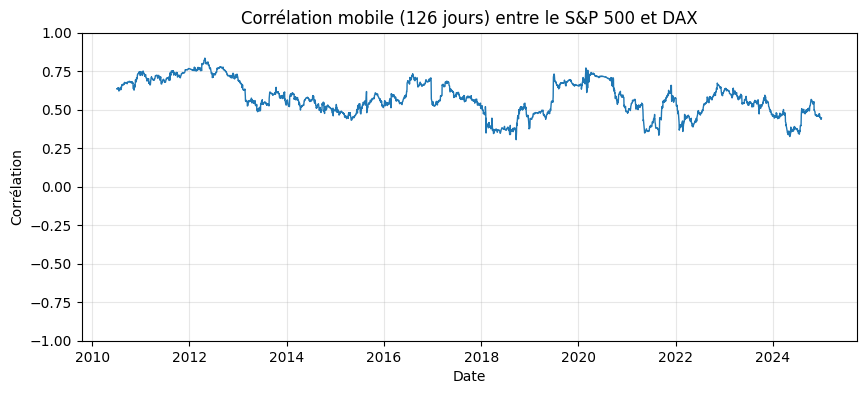

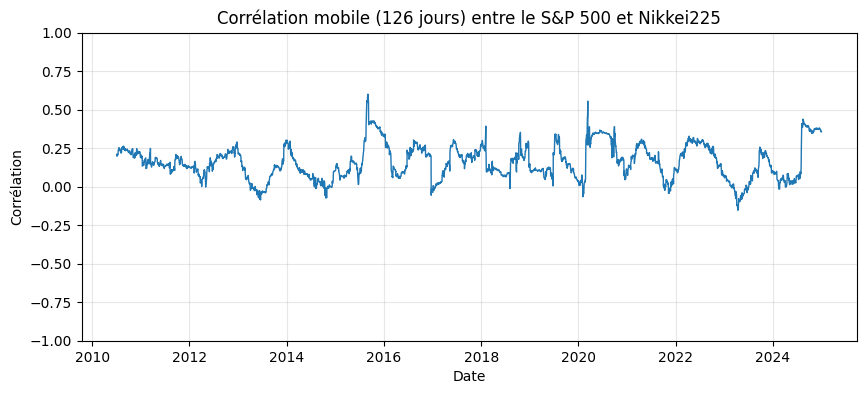

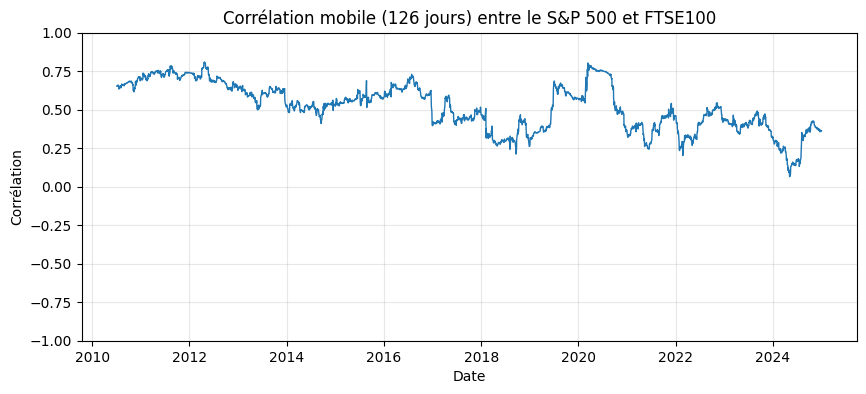

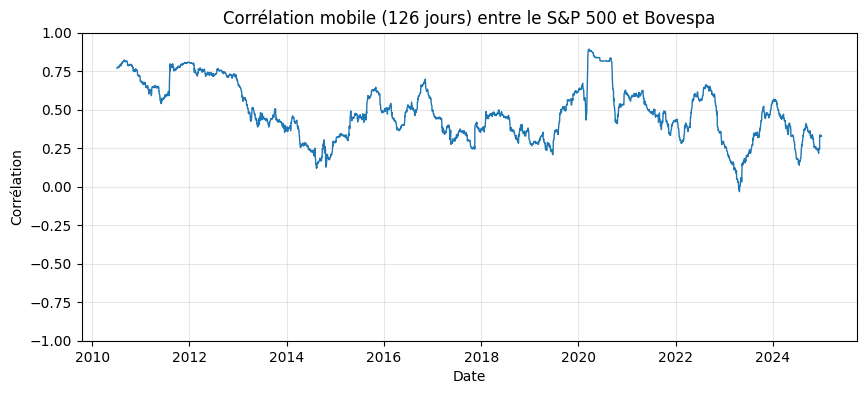

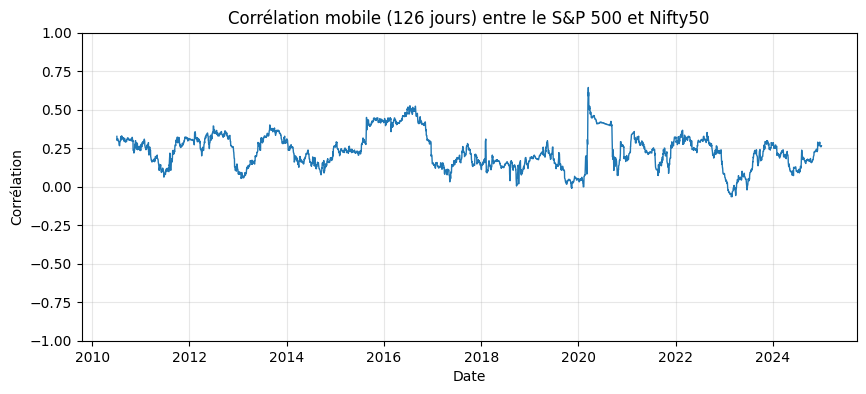

In [24]:
# Graphique des corrélations mobiles
plt.figure(figsize=(12,6))
for col in corr_mob.columns:
    plt.figure(figsize=(10,4))
    plt.plot(corr_mob.index, corr_mob[col], color='tab:blue', linewidth=1)
    plt.title(f"Corrélation mobile (126 jours) entre le S&P 500 et {col.replace('corr_SP500_', '')}")
    plt.xlabel("Date")
    plt.ylabel("Corrélation")
    plt.grid(alpha=0.3)
    plt.ylim(-1, 1)
    plt.show()

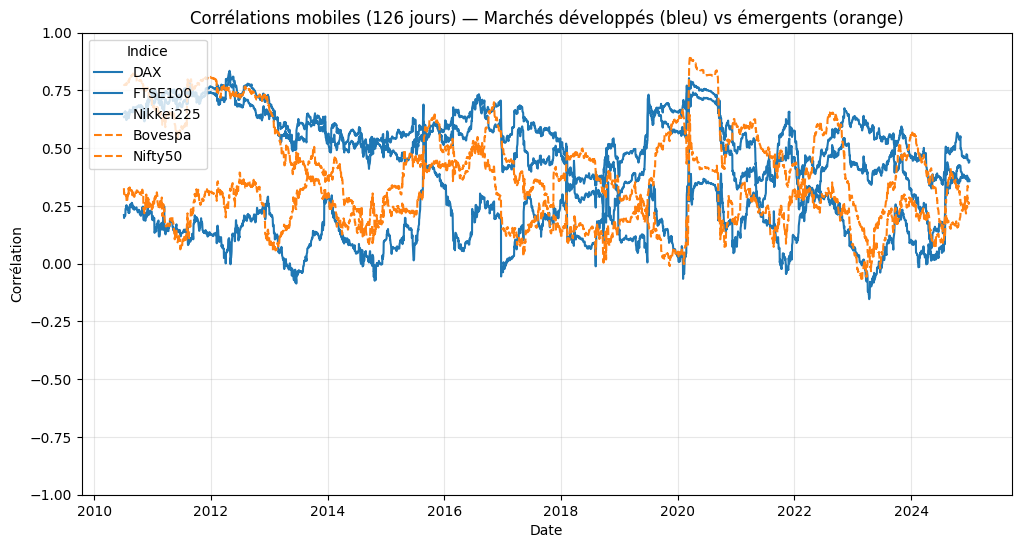

In [35]:
# Graphique comparant corrélation SP500 avec marché développés et émergents
developed = ['corr_SP500_DAX', 'corr_SP500_FTSE100', 'corr_SP500_Nikkei225']
emerging = ['corr_SP500_Bovespa', 'corr_SP500_Nifty50']

plt.figure(figsize=(12,6))

for col in developed:
    plt.plot(corr_mob.index, corr_mob[col], linewidth=1.5, label=col.replace('corr_SP500_', ''), color='tab:blue')

for col in emerging:
    plt.plot(corr_mob.index, corr_mob[col], linewidth=1.5, linestyle='--', label=col.replace('corr_SP500_', ''), color='tab:orange')

plt.title("Corrélations mobiles (126 jours) — Marchés développés (bleu) vs émergents (orange)")
plt.xlabel("Date")
plt.ylabel("Corrélation")
plt.ylim(-1, 1)
plt.legend(title="Indice", loc='upper left')
plt.grid(alpha=0.3)
plt.show()

In [25]:
# Importation VIX
vix_query = """
SELECT
    date AS datadate,
    vix AS vix_value
FROM cboe.cboe
WHERE date >= '2010-01-01'
  AND date <= '2024-12-31'
  AND vix IS NOT NULL
ORDER BY date
"""

df_vix = db.raw_sql(vix_query)
df_vix['datadate'] = pd.to_datetime(df_vix['datadate'])
df_vix = df_vix.set_index('datadate')
df_vix['log_VIX'] = np.log(df_vix['vix_value'])

print("VIX :")
print(df_vix)

corr_mob_vix = corr_mob.join(df_vix['log_VIX'], how='inner').dropna()

print("\nFusion corrélations et log(VIX) :")
print(corr_mob_vix)

VIX :
            vix_value   log_VIX
datadate                       
2010-01-04      20.04   2.99773
2010-01-05      19.35  2.962692
2010-01-06      19.16  2.952825
2010-01-07      19.06  2.947592
2010-01-08      18.13  2.897568
...               ...       ...
2024-12-24      14.27  2.658159
2024-12-26      14.73  2.689886
2024-12-27      15.95  2.769459
2024-12-30       17.4   2.85647
2024-12-31      17.35  2.853593

[3793 rows x 2 columns]

Fusion corrélations et log(VIX) :
            corr_SP500_DAX  corr_SP500_Nikkei225  corr_SP500_FTSE100  \
2010-07-06        0.635893              0.210762            0.652437   
2010-07-07        0.633235              0.197942            0.651739   
2010-07-08        0.634284              0.206302            0.653415   
2010-07-09        0.635668              0.208772            0.654471   
2010-07-12        0.635538              0.207499            0.653911   
...                    ...                   ...                 ...   
2024-12-24    

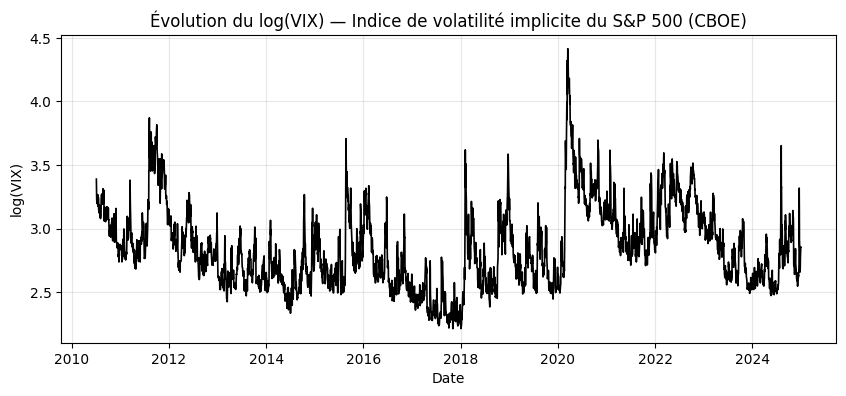

In [26]:
# Graphique log(VIX)
plt.figure(figsize=(10,4))
plt.plot(corr_mob_vix.index, corr_mob_vix['log_VIX'], color='black', linewidth=1.2)
plt.title("Évolution du log(VIX) — Indice de volatilité implicite du S&P 500 (CBOE)")
plt.xlabel("Date")
plt.ylabel("log(VIX)")
plt.grid(alpha=0.3)
plt.show()

In [27]:
# Calcul statistiques descriptives
def acf1(x):
    x = x.dropna()
    return x.autocorr(lag=1)

desc = corr_mob_vix.agg(['mean','std','min','max'])
q = corr_mob_vix.quantile([0.05,0.50,0.95])
acf1_vals = corr_mob_vix.apply(acf1)

print("Statistiques descriptives (moy, écart-type, min, max) pour chaque corrélation:")
print(desc.round(3))

print("\nQuantiles (5%, 50%, 95%) :")
print(q.round(3))

print("\nAutocorrélation au lag 1 :")
print(acf1_vals.round(3))

Statistiques descriptives (moy, écart-type, min, max) pour chaque corrélation:
      corr_SP500_DAX  corr_SP500_Nikkei225  corr_SP500_FTSE100  \
mean           0.574                 0.160               0.517   
std            0.111                 0.112               0.153   
min            0.305                -0.153               0.065   
max            0.835                 0.601               0.810   

      corr_SP500_Bovespa  corr_SP500_Nifty50  log_VIX  
mean               0.483               0.231    2.846  
std                0.182               0.114    0.319  
min               -0.032              -0.065    2.213  
max                0.893               0.645    4.415  

Quantiles (5%, 50%, 95%) :
      corr_SP500_DAX  corr_SP500_Nikkei225  corr_SP500_FTSE100  \
0.05           0.375                -0.012               0.274   
0.50           0.565                 0.150               0.525   
0.95           0.751                 0.361               0.747   

      corr_SP500_

In [37]:
# Test de Dickey-Fuller Augmenté
def adf_summary(series):
    s = series.dropna()
    res = adfuller(s, regression='c', autolag='AIC')  
    out = {
        'ADF_stat': res[0],
        'p_value':  res[1],
        'lags':     res[2],
        'n_obs':    res[3],
        'Conclusion': 'Stationnaire' if res[1] < 0.05 else 'Non-stationnaire'
    }
    return pd.Series(out)

adf_table = corr_mob.apply(adf_summary).T
print("Tests ADF (constante) :")
print(adf_table.round(4))

Tests ADF (constante) :
                      ADF_stat   p_value lags n_obs        Conclusion
corr_SP500_DAX       -3.087255  0.027511   17  3629      Stationnaire
corr_SP500_Nikkei225 -4.366951  0.000339   13  3633      Stationnaire
corr_SP500_FTSE100   -2.378747  0.147825    3  3643  Non-stationnaire
corr_SP500_Bovespa   -3.048849  0.030578    6  3640      Stationnaire
corr_SP500_Nifty50   -3.854658  0.002395    8  3638      Stationnaire


In [38]:
# Test KPSS complémentaire
def kpss_summary(series):
    s = series.dropna()
    res = kpss(s, regression='c', nlags='auto')
    out = {
        'KPSS_stat': res[0],
        'p_value': res[1],
        'lags': res[2],
        'n_obs': len(s),
        'Conclusion': 'Stationnaire' if res[1] > 0.05 else 'Non-stationnaire'
    }
    return pd.Series(out)

kpss_table = corr_mob.apply(kpss_summary).T
print("Tests KPSS (constante) :")
print(kpss_table.round(4))

Tests KPSS (constante) :
                     KPSS_stat   p_value lags n_obs        Conclusion
corr_SP500_DAX        2.533298      0.01   38  3647  Non-stationnaire
corr_SP500_Nikkei225  0.181811       0.1   38  3647      Stationnaire
corr_SP500_FTSE100    4.736911      0.01   38  3647  Non-stationnaire
corr_SP500_Bovespa    1.724129      0.01   38  3647  Non-stationnaire
corr_SP500_Nifty50    0.686996  0.014728   38  3647  Non-stationnaire


/var/folders/bx/rtwm1h_55kq4g_m48zp38fnm0000gp/T/ipykernel_96848/2960438973.py:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  res = kpss(s, regression='c', nlags='auto')
/var/folders/bx/rtwm1h_55kq4g_m48zp38fnm0000gp/T/ipykernel_96848/2960438973.py:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  res = kpss(s, regression='c', nlags='auto')
/var/folders/bx/rtwm1h_55kq4g_m48zp38fnm0000gp/T/ipykernel_96848/2960438973.py:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  res = kpss(s, regression='c', nlags='auto')
/var/folders/bx/rtwm1h_55kq4g_m48zp38fnm0000gp/T/ipykernel_96848/2960438973.py:4: InterpolationWarning: The test st

# PARTIE 2.2

##### Étapes à suivre: 
- Choisir modèle corrélation (en niveau ou différence)
- Comparer la performance hors échantillon avec le RMSE
- Visualiser les prévisions vs valeurs réelles (avec intervalle confiance à 95%)
- Interprétation

In [ ]:
corr_diff = corr_mob.diff().dropna()

# Cas fixes selon 2.1 :
# FTSE100 = non stationnaire donc toujours en différence
# Nikkei225 = stationnaire donc toujours en niveau
# Les trois autres = incertains 
always_diff = ['corr_SP500_FTSE100']
always_level = ['corr_SP500_Nikkei225']
ambiguous = ['corr_SP500_DAX', 'corr_SP500_Bovespa', 'corr_SP500_Nifty50']

In [67]:
# Choix modèles niveau et différences pour séries
results_final = {}
rmse_comparison = {}   

test_size = 30
train = corr_mob.iloc[:-test_size]
test = corr_mob.iloc[-test_size:]

for col in corr_mob.columns:
    series_train = train[col].dropna()
    series_diff_train = train[col].diff().dropna()
    best_type = None
    best_rmse = np.inf
    best_pred = None
    best_p = None

    # Cas trouvés en 2.1
    if col in always_level:
        modes_to_test = ['niveau']
    elif col in always_diff:
        modes_to_test = ['différence']
    else:
        modes_to_test = ['niveau', 'différence']

    rmse_comparison[col] = {}  

    for mode in modes_to_test:
        if mode == 'niveau':
            data_train = series_train
        else:
            data_train = series_diff_train

        # Trouver p optimal via BIC (max lag = 10)
        try:
            order_sel = arma_order_select_ic(data_train, ic='bic', max_ar=10, trend='c')
            best_p_auto = order_sel['bic_min_order'][0]
        except Exception:
            best_p_auto = 1

        # Ajuster le modèle
        model = AutoReg(data_train, lags=best_p_auto, old_names=False)
        res = model.fit()

        # Prévision sur 30 jours
        pred = res.predict(start=len(data_train), end=len(data_train) + len(test) - 1, dynamic=False)

        if mode == 'différence':
            pred = test[col].iloc[0] + pred.cumsum()

        # Calcul du RMSE
        rmse = np.sqrt(mean_squared_error(test[col], pred))
        rmse_comparison[col][mode] = rmse  

        # Choix du meilleur modèle
        if rmse < best_rmse:
            best_rmse = rmse
            best_type = mode
            best_pred = pred
            best_p = best_p_auto

    results_final[col] = {
        'modele_retenu': best_type,
        'p': best_p,
        'RMSE': best_rmse,
        'Prévision': best_pred
    }

# Tableau comparatif des deux RMSE 
comparison_table = pd.DataFrame(rmse_comparison).T
comparison_table = comparison_table[['niveau', 'différence']]  
print("\nCOMPARAISON DES RMSE (NIVEAU VS DIFFÉRENCE)")
print(comparison_table.round(4))

# Tableau final
final_table = pd.DataFrame(results_final).T[['modele_retenu', 'p', 'RMSE']]
print("\nMEILLEUR MODÈLE RETENU POUR CHAQUE SÉRIE")
print(final_table.round(4))


/Users/lilas/Library/Caches/pypoetry/virtualenvs/sandbox-P7ZUWdPW-py3.13/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/lilas/Library/Caches/pypoetry/virtualenvs/sandbox-P7ZUWdPW-py3.13/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/lilas/Library/Caches/pypoetry/virtualenvs/sandbox-P7ZUWdPW-py3.13/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/lilas/Library/Caches/pypoetry/virtualenvs/sandbox-P7ZUWdPW-py3.13/lib/python3.13/site-packages/statsmodels


COMPARAISON DES RMSE (NIVEAU VS DIFFÉRENCE)
                      niveau  différence
corr_SP500_DAX        0.0190      0.0107
corr_SP500_Nikkei225  0.0391         NaN
corr_SP500_FTSE100       NaN      0.0139
corr_SP500_Bovespa    0.0383      0.0433
corr_SP500_Nifty50    0.0376      0.0389

MEILLEUR MODÈLE RETENU POUR CHAQUE SÉRIE
                     modele_retenu  p      RMSE
corr_SP500_DAX          différence  0   0.01074
corr_SP500_Nikkei225        niveau  1  0.039076
corr_SP500_FTSE100      différence  3  0.013935
corr_SP500_Bovespa          niveau  2  0.038278
corr_SP500_Nifty50          niveau  1  0.037614


/Users/lilas/Library/Caches/pypoetry/virtualenvs/sandbox-P7ZUWdPW-py3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/lilas/Library/Caches/pypoetry/virtualenvs/sandbox-P7ZUWdPW-py3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/lilas/Library/Caches/pypoetry/virtualenvs/sandbox-P7ZUWdPW-py3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/lilas/Library/Caches/pypoetry/virtualenvs/sandbox-P7ZUWdPW

In [71]:
from statsmodels.tsa.ar_model import AutoReg
import pandas as pd
import numpy as np

fit_store = {}
coef_rows = []

for col, res in results_final.items():
    y = corr_mob[col].copy()

    # Si différence, on la calcule et on enlève les NaN
    if res['modele_retenu'] == 'différence':
        y = y.diff()

    # Harmonisation de la fréquence
    y = y.asfreq('B').dropna()  # <<< ICI le dropna est essentiel

    # Vérification (optionnelle)
    if y.isna().any():
        print(f"⚠️ Série {col} contient encore des NaN après nettoyage")

    # Ajustement AR(p)
    mod = AutoReg(y, lags=res['p'], old_names=False).fit()
    fit_store[col] = mod

    # Sauvegarde des coefficients + erreurs-types
    params = mod.params
    ses = mod.bse
    for name in params.index:
        coef_rows.append({
            'Série': col.replace('corr_SP500_', ''),
            'Paramètre': name,
            'Coef': params[name],
            'SE': ses[name]
        })

coef_table = pd.DataFrame(coef_rows).pivot(index='Paramètre', columns='Série', values='Coef').round(4)
se_table = pd.DataFrame(coef_rows).pivot(index='Paramètre', columns='Série', values='SE').round(4)

print("\n=== Coefficients estimés (AR(p)) ===")
print(coef_table.fillna(''))
print("\n=== Erreurs-types (SE) correspondantes ===")
print(se_table.fillna(''))



=== Coefficients estimés (AR(p)) ===
Série                   Bovespa     DAX FTSE100 Nifty50 Nikkei225
Paramètre                                                        
const                     0.001 -0.0001 -0.0001  0.0019    0.0019
corr_SP500_Bovespa.L1    1.0464                                  
corr_SP500_Bovespa.L2   -0.0488                                  
corr_SP500_FTSE100.L1                    0.0126                  
corr_SP500_FTSE100.L2                   -0.0508                  
corr_SP500_FTSE100.L3                    0.0739                  
corr_SP500_Nifty50.L1                            0.9915          
corr_SP500_Nikkei225.L1                                    0.9882

=== Erreurs-types (SE) correspondantes ===
Série                   Bovespa     DAX FTSE100 Nifty50 Nikkei225
Paramètre                                                        
const                    0.0005  0.0002  0.0002  0.0006    0.0005
corr_SP500_Bovespa.L1    0.0165                             

/Users/lilas/Library/Caches/pypoetry/virtualenvs/sandbox-P7ZUWdPW-py3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/lilas/Library/Caches/pypoetry/virtualenvs/sandbox-P7ZUWdPW-py3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/lilas/Library/Caches/pypoetry/virtualenvs/sandbox-P7ZUWdPW-py3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/lilas/Library/Caches/pypoetry/virtualenvs/sandbox-P7ZUWdP

In [84]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.ar_model import AutoReg

H = 90  # horizon hors échantillon (≈ un trimestre)
oos_results = {}
oos_preds   = {}
oos_ic      = {}

start_oos_index = corr_mob.index[-H]

for col, res in results_final.items():
    # 1) Série au bon format selon le choix niveau/diff
    y_full = corr_mob[col].copy()
    if res['modele_retenu'] == 'différence':
        y_full = y_full.diff()
    # fréquence jours ouvrés + purge NaN
    y_full = y_full.asfreq('B').dropna()

    # 2) Split train/test sur les H derniers points
    y_train_full = y_full.loc[: start_oos_index - pd.tseries.offsets.BDay(1)]
    y_test_full  = y_full.loc[start_oos_index:].copy()

    preds_pairs, low_pairs, up_pairs = [], [], []
    hist = y_train_full.copy()
    p = int(res['p'])

    # 3) Boucle récursive 1-pas
    for idx, y_true_t in y_test_full.items():
        # ré-estime AR(p) sur l'historique courant
        mod = AutoReg(hist, lags=p, old_names=False).fit()

        # prédiction 1-pas
        if p == 0:
            y_hat = mod.params[0]
        elif p == 1:
            y_hat = mod.params[0] + mod.params[1] * hist.iloc[-1]
        else:
            y_hat = mod.params[0] + np.dot(mod.params[1:].values, hist.iloc[-p:].values)

        preds_pairs.append((idx, y_hat))

        # IC 95 % (1-pas) avec sigma des résidus
        sigma = float(mod.resid.std())
        low_pairs.append((idx, y_hat - 1.96 * sigma))
        up_pairs.append((idx,  y_hat + 1.96 * sigma))

    # 4) Construction des séries + alignement strict + purge NaN
    preds = pd.Series(dict(preds_pairs)).sort_index()
    lower = pd.Series(dict(low_pairs)).sort_index()
    upper = pd.Series(dict(up_pairs)).sort_index()

    # aligner toutes les séries sur l'intersection d'index
    common_idx   = y_test_full.index.intersection(preds.index)
    y_test_full  = y_test_full.loc[common_idx]
    preds        = preds.loc[common_idx]
    lower        = lower.loc[common_idx]
    upper        = upper.loc[common_idx]

    # sécurité : drop des éventuels NaN restants
    df_tmp = pd.DataFrame({'y': y_test_full, 'pred': preds, 'lo': lower, 'hi': upper}).dropna()
    y_test_full = df_tmp['y']
    preds       = df_tmp['pred']
    lower       = df_tmp['lo']
    upper       = df_tmp['hi']

    # 5) Métriques
    rmse = float(np.sqrt(mean_squared_error(y_test_full, preds)))
    coverage = float(((y_test_full >= lower) & (y_test_full <= upper)).mean())

    # 6) Stockage
    oos_results[col] = {'RMSE_test': rmse, 'Coverage_95%': coverage}
    oos_preds[col]   = preds
    oos_ic[col]      = (lower, upper)

# aperçu
pd.DataFrame(oos_results).T.round(6)


/Users/lilas/Library/Caches/pypoetry/virtualenvs/sandbox-P7ZUWdPW-py3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/var/folders/bx/rtwm1h_55kq4g_m48zp38fnm0000gp/T/ipykernel_96848/2369604512.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_hat = mod.params[0]
/Users/lilas/Library/Caches/pypoetry/virtualenvs/sandbox-P7ZUWdPW-py3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/var/folders/bx/rtwm1h_55kq4g_m48zp38

,RMSE_test,Coverage_95%
corr_SP500_DAX,0.008449,0.977778
corr_SP500_Nikkei225,0.030983,0.711111
corr_SP500_FTSE100,0.007545,0.977778
corr_SP500_Bovespa,0.067824,0.266667
corr_SP500_Nifty50,0.053072,0.566667


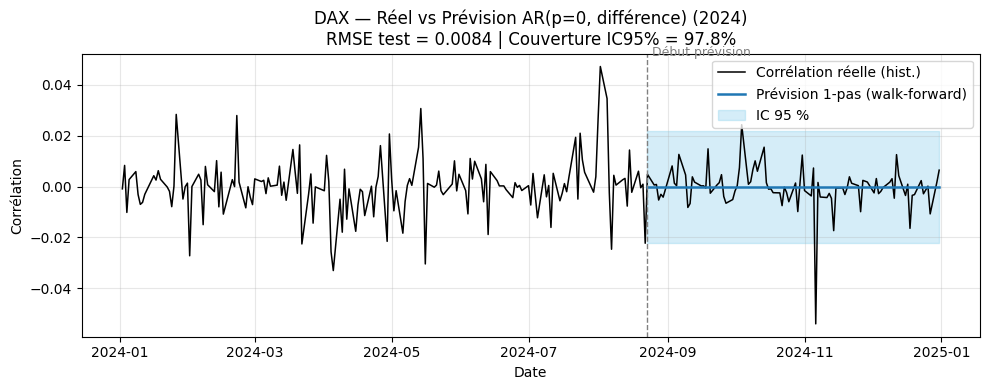

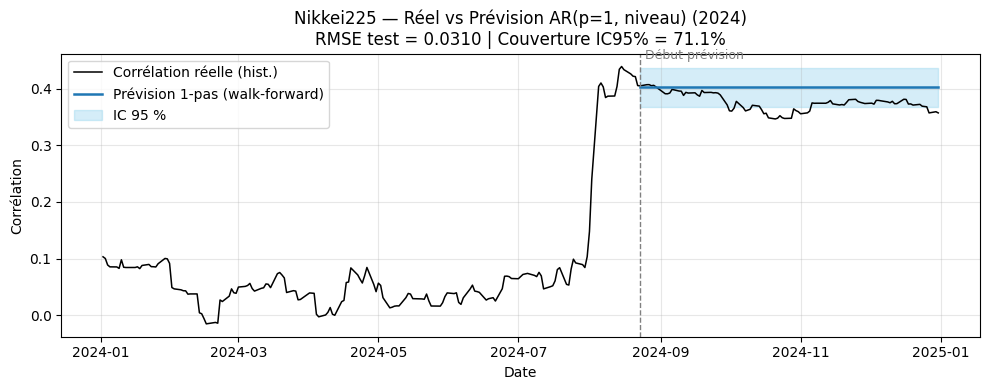

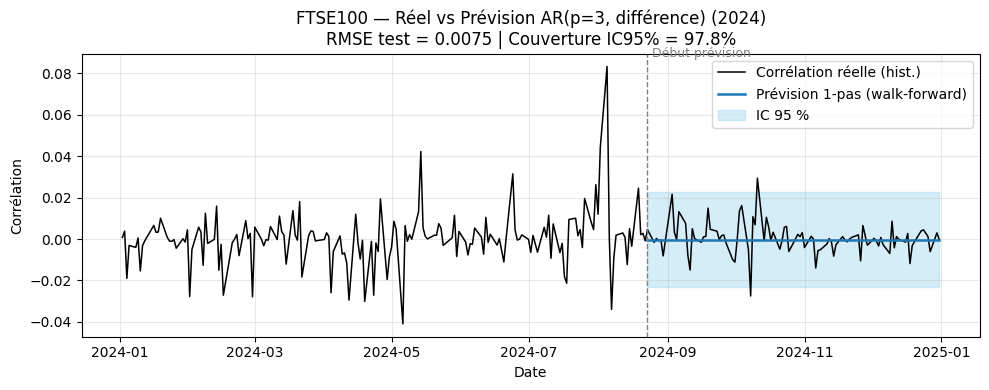

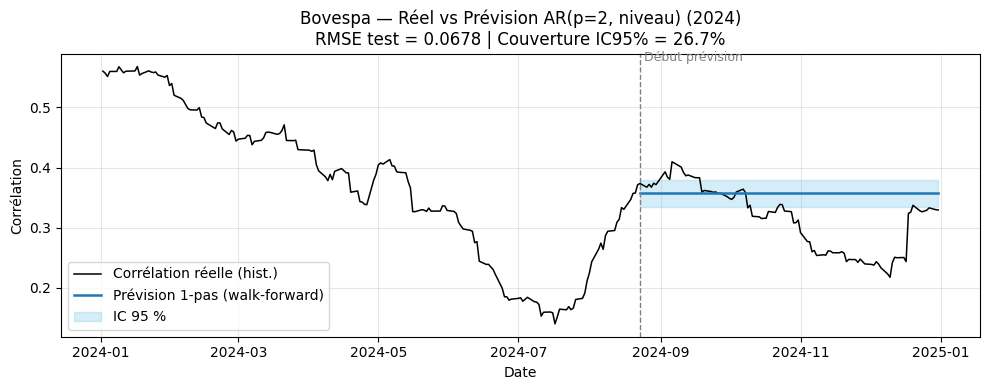

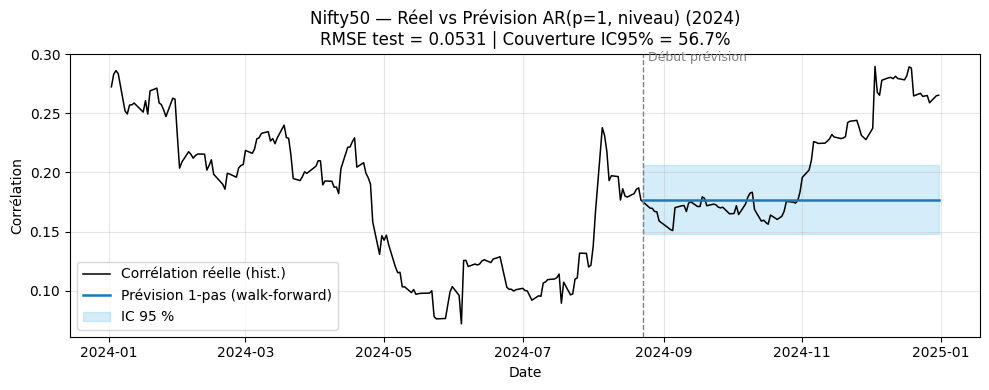

In [86]:
import matplotlib.pyplot as plt

start_zoom = pd.Timestamp("2024-01-01")

for col, res in results_final.items():
    y_plot = corr_mob[col].copy()
    if res['modele_retenu'] == 'différence':
        y_plot = y_plot.diff()

    # séries pour la figure
    pred  = oos_preds[col]
    low, up = oos_ic[col]

    plt.figure(figsize=(10,4))
    plt.plot(y_plot.loc[start_zoom:], color='black', label='Corrélation réelle (hist.)', linewidth=1.1)
    plt.plot(pred.loc[start_zoom:],  color='tab:blue', label='Prévision 1-pas (walk-forward)', linewidth=1.8)
    plt.fill_between(pred.loc[start_zoom:].index,
                     low.loc[start_zoom:], up.loc[start_zoom:],
                     color='skyblue', alpha=0.35, label='IC 95 %')

    # ligne pointillée = début test
    plt.axvline(start_oos_index, color='gray', linestyle='--', linewidth=1)
    plt.text(start_oos_index + pd.Timedelta(days=2), plt.ylim()[1]*0.98,
             'Début prévision', color='gray', fontsize=9)

    r = oos_results[col]
    titre = f"{col.replace('corr_SP500_','')} — Réel vs Prévision AR(p={res['p']}, {res['modele_retenu']}) (2024)\n" \
            f"RMSE test = {r['RMSE_test']:.4f} | Couverture IC95% = {100*r['Coverage_95%']:.1f}%"
    plt.title(titre)
    plt.xlabel("Date"); plt.ylabel("Corrélation")
    plt.legend(); plt.grid(alpha=0.3); plt.tight_layout()
    plt.show()


In [88]:
from statsmodels.stats.diagnostic import acorr_ljungbox, normal_ad
from scipy.stats import jarque_bera
import pandas as pd

diag_rows = []
for col, mod in fit_store.items():
    resid = mod.resid.dropna()
    
    # Test de Ljung-Box (autocorrélation des résidus)
    lb_p = acorr_ljungbox(resid, lags=[10], return_df=True)['lb_pvalue'].iloc[0]
    
    # Test de Jarque-Bera (normalité)
    jb_stat, jb_p = jarque_bera(resid)
    
    # Test d’Anderson-Darling (normalité)
    ad_stat, ad_p = normal_ad(resid)
    
    diag_rows.append({
        'Série': col.replace('corr_SP500_', ''),
        'Ljung-Box p(10)': lb_p,
        'Jarque-Bera p': jb_p,
        'AD-normalité p': float(ad_p)
    })

diagnostics = pd.DataFrame(diag_rows).set_index('Série').round(4)
print("\n=== Diagnostics des résidus (in-sample) ===")
print(diagnostics)



=== Diagnostics des résidus (in-sample) ===
           Ljung-Box p(10)  Jarque-Bera p  AD-normalité p
Série                                                    
DAX                 0.0010            0.0             0.0
Nikkei225           0.0000            0.0             0.0
FTSE100             0.4846            0.0             0.0
Bovespa             0.0000            0.0             0.0
Nifty50             0.0007            0.0             0.0


In [91]:
final_rows = []
for col, res in results_final.items():
    serie = col.replace('corr_SP500_','')
    rmse_tr = res['RMSE']
    rmse_ts = oos_results[col]['RMSE_test']
    cover   = oos_results[col]['Coverage_95%']
    lb_p    = diagnostics.loc[serie, 'Ljung-Box p(10)']
    jb_p    = diagnostics.loc[serie, 'Jarque-Bera p']

    final_rows.append({
        'Série': serie,
        'Type' : res['modele_retenu'],
        'p'    : res['p'],
        'RMSE_train': rmse_tr,
        'RMSE_test' : rmse_ts,
        'Coverage_IC95%': cover,
        'LjungBox_p10': lb_p,
        'JarqueBera_p': jb_p
    })

final_table = pd.DataFrame(final_rows).set_index('Série').round(6).sort_index()
print("\n=== Tableau final – Section 2.2 (complet) ===")
print(final_table)



=== Tableau final – Section 2.2 (complet) ===
                 Type  p  RMSE_train  RMSE_test  Coverage_IC95%  LjungBox_p10  \
Série                                                                           
Bovespa        niveau  2    0.038278   0.067824        0.266667        0.0000   
DAX        différence  0    0.010740   0.008449        0.977778        0.0010   
FTSE100    différence  3    0.013935   0.007545        0.977778        0.4846   
Nifty50        niveau  1    0.037614   0.053072        0.566667        0.0007   
Nikkei225      niveau  1    0.039076   0.030983        0.711111        0.0000   

           JarqueBera_p  
Série                    
Bovespa             0.0  
DAX                 0.0  
FTSE100             0.0  
Nifty50             0.0  
Nikkei225           0.0  


# PARTIE 2.3

##### Étapes à suivre:
- Récupérer les données VIX, calculer log;
- Estimer les deux modèles (linéraire et quadratique) pour chacun des 5 marchés;
- Tableaux pour chaque marché comprenant (coef, standerr, t-stat, p-value, R^2, R^2 ajusté);
- Tester significativité terme quadratique;
- Calculer point de bascule 
- Graphique 


In [115]:
corr_mob_vix["log_VIX_c"] = corr_mob_vix["log_VIX"] - corr_mob_vix["log_VIX"].mean()
corr_mob_vix["log_VIX_c2"] = corr_mob_vix["log_VIX_c"] ** 2

markets = ["corr_SP500_DAX", "corr_SP500_Nikkei225", "corr_SP500_FTSE100", "corr_SP500_Bovespa", "corr_SP500_Nifty50"]

In [116]:
results_lin = {}
results_quad = {}

for col in markets:
    y = corr_mob_vix[col].astype(float).dropna()

    X_lin = sm.add_constant(corr_mob_vix.loc[y.index, ["log_VIX_c"]].astype(float))
    X_quad = sm.add_constant(corr_mob_vix.loc[y.index, ["log_VIX_c", "log_VIX_c2"]].astype(float))
    
    mod_lin = sm.OLS(y, X_lin, cov_type='HAC', cov_kwds={'maxlags':5}).fit()
    mod_quad = sm.OLS(y, X_quad, cov_type='HAC', cov_kwds={'maxlags':5}).fit()
    
    results_lin[col] = mod_lin
    results_quad[col] = mod_quad

/Users/lilas/Library/Caches/pypoetry/virtualenvs/sandbox-P7ZUWdPW-py3.13/lib/python3.13/site-packages/statsmodels/base/model.py:130: ValueWarning: unknown kwargs ['cov_type', 'cov_kwds']
  warnings.warn(msg, ValueWarning)
/Users/lilas/Library/Caches/pypoetry/virtualenvs/sandbox-P7ZUWdPW-py3.13/lib/python3.13/site-packages/statsmodels/base/model.py:130: ValueWarning: unknown kwargs ['cov_type', 'cov_kwds']
  warnings.warn(msg, ValueWarning)
/Users/lilas/Library/Caches/pypoetry/virtualenvs/sandbox-P7ZUWdPW-py3.13/lib/python3.13/site-packages/statsmodels/base/model.py:130: ValueWarning: unknown kwargs ['cov_type', 'cov_kwds']
  warnings.warn(msg, ValueWarning)
/Users/lilas/Library/Caches/pypoetry/virtualenvs/sandbox-P7ZUWdPW-py3.13/lib/python3.13/site-packages/statsmodels/base/model.py:130: ValueWarning: unknown kwargs ['cov_type', 'cov_kwds']
  warnings.warn(msg, ValueWarning)
/Users/lilas/Library/Caches/pypoetry/virtualenvs/sandbox-P7ZUWdPW-py3.13/lib/python3.13/site-packages/statsmodel

In [120]:
lin_table = pd.DataFrame({
    "β₀": [r.params["const"] for r in results_lin.values()],
    "β₁": [r.params["log_VIX_c"] for r in results_lin.values()],
    "SE_β₁": [r.bse["log_VIX_c"] for r in results_lin.values()],
    "R²_adj": [r.rsquared_adj for r in results_lin.values()],
    "AIC": [r.aic for r in results_lin.values()],
    "BIC": [r.bic for r in results_lin.values()]
}, index=[c.replace("corr_SP500_", "") for c in markets])

quad_table = pd.DataFrame({
    "β₀": [r.params["const"] for r in results_quad.values()],
    "β₁": [r.params["log_VIX_c"] for r in results_quad.values()],
    "β₂": [r.params["log_VIX_c2"] for r in results_quad.values()],
    "SE_β₂": [r.bse["log_VIX_c2"] for r in results_quad.values()],
    "R²_adj": [r.rsquared_adj for r in results_quad.values()],
    "AIC": [r.aic for r in results_quad.values()],
    "BIC": [r.bic for r in results_quad.values()],
    "β₁<0, β₂>0": [(r.params["log_VIX_c"] < 0) and (r.params["log_VIX_c2"] > 0) for r in results_quad.values()],
    "VIX*": [np.exp(-r.params["log_VIX_c"] / (2*r.params["log_VIX_c2"])) 
             if (r.params["log_VIX_c2"] > 0) and (r.params["log_VIX_c"] < 0) else "—"
             for r in results_quad.values()]
}, index=[c.replace("corr_SP500_", "") for c in markets])

print("=== Modèle linéaire : Corr = β₀ + β₁ log(VIX) ===")
print(lin_table.round(4), "\n")

print("=== Modèle quadratique : Corr = β₀ + β₁ log(VIX) + β₂ (log(VIX))² ===")
print(quad_table.round(4))


=== Modèle linéaire : Corr = β₀ + β₁ log(VIX) ===
               β₀      β₁   SE_β₁  R²_adj        AIC        BIC
DAX        0.5739  0.0727  0.0057  0.0431 -5827.4801 -5815.0768
Nikkei225  0.1602  0.1141  0.0055  0.1042 -5986.8694 -5974.4661
FTSE100    0.5172  0.1045  0.0077  0.0474 -3542.4326 -3530.0293
Bovespa    0.4832  0.2620  0.0084  0.2091 -2913.0910 -2900.6877
Nifty50    0.2314  0.1022  0.0057  0.0818 -5819.2379 -5806.8346 

=== Modèle quadratique : Corr = β₀ + β₁ log(VIX) + β₂ (log(VIX))² ===
               β₀      β₁      β₂   SE_β₂  R²_adj        AIC        BIC  \
DAX        0.5689  0.0600  0.0492  0.0118  0.0474 -5842.8942 -5824.2893   
Nikkei225  0.1532  0.0961  0.0696  0.0115  0.1129 -6021.2910 -6002.6860   
FTSE100    0.5106  0.0876  0.0654  0.0161  0.0515 -3556.8646 -3538.2596   
Bovespa    0.4798  0.2534  0.0330  0.0176  0.2097 -2914.6066 -2896.0017   
Nifty50    0.2271  0.0913  0.0422  0.0118  0.0847 -5829.9765 -5811.3715   

           β₁<0, β₂>0 VIX*  
DAX           

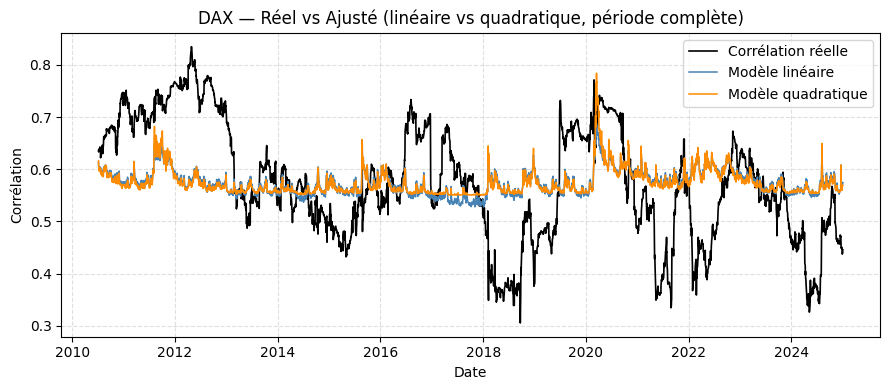

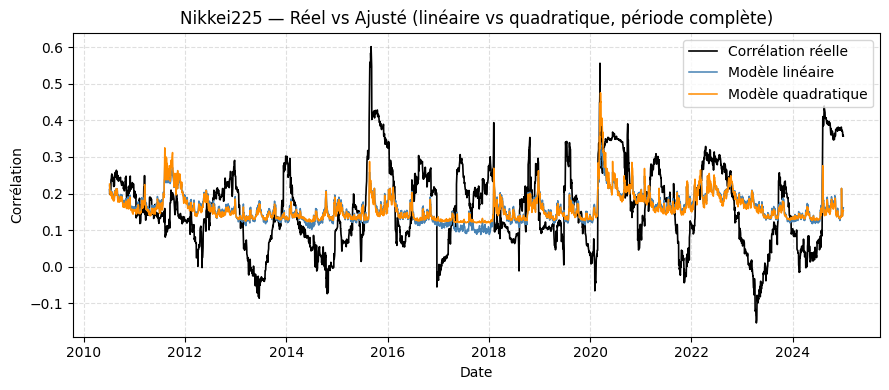

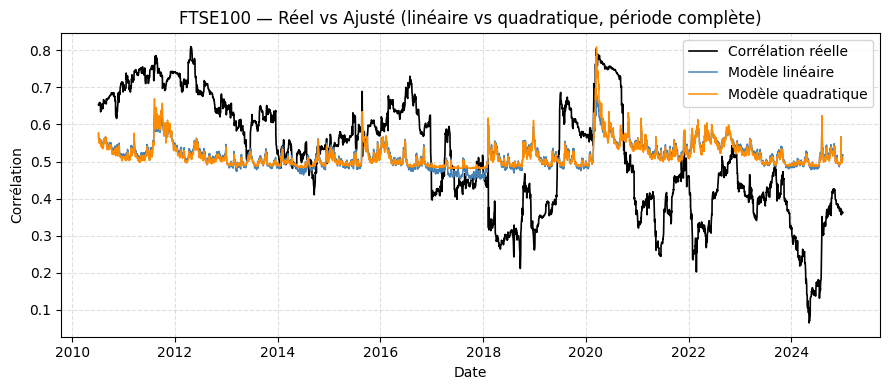

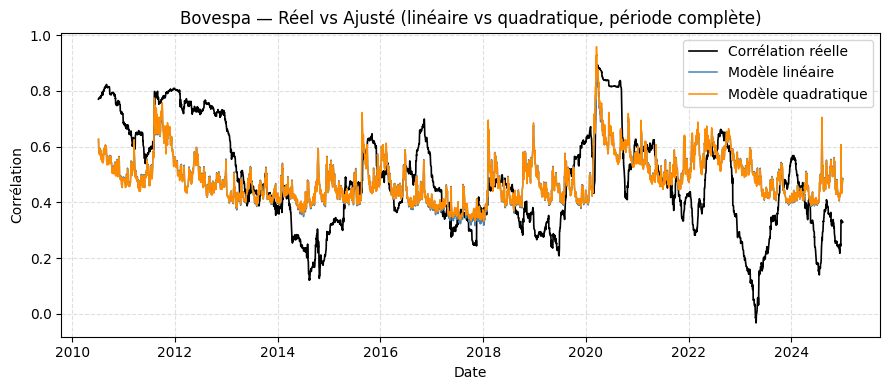

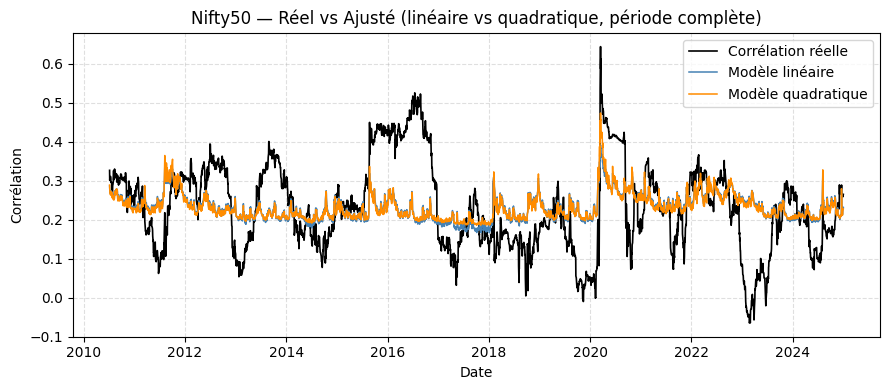

In [118]:
for col in markets:
    y = corr_mob_vix[col].dropna()
    y_hat_lin = results_lin[col].fittedvalues
    y_hat_quad = results_quad[col].fittedvalues

    plt.figure(figsize=(9, 4))
    plt.plot(y.index, y, color='black', linewidth=1.2, label='Corrélation réelle')
    plt.plot(y_hat_lin.index, y_hat_lin, color='steelblue', linewidth=1.1, label='Modèle linéaire')
    plt.plot(y_hat_quad.index, y_hat_quad, color='darkorange', linewidth=1.1, label='Modèle quadratique')
    plt.title(f"{col.replace('corr_SP500_', '')} — Réel vs Ajusté (linéaire vs quadratique, période complète)")
    plt.xlabel("Date")
    plt.ylabel("Corrélation")
    plt.legend(loc="upper right")
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.tight_layout()
    plt.show()

In [122]:

summary_table = []

for col, mod in results_quad.items():
    b0 = mod.params["const"]
    b1 = mod.params["log_VIX_c"]
    b2 = mod.params["log_VIX_c2"]

    se_b1 = mod.bse["log_VIX_c"]
    se_b2 = mod.bse["log_VIX_c2"]
    p_b1 = mod.pvalues["log_VIX_c"]
    p_b2 = mod.pvalues["log_VIX_c2"]

    r2 = mod.rsquared_adj
    aic = mod.aic
    bic = mod.bic

    convexe = (b1 < 0) and (b2 > 0)
    significatif = (p_b1 < 0.05) or (p_b2 < 0.05)
    point_bascule = np.exp(-b1 / (2*b2)) if convexe and (b2 != 0) else "—"

    summary_table.append({
        "Série": col.replace("corr_SP500_", ""),
        "β₀": round(b0, 4),
        "β₁": round(b1, 4),
        "β₂": round(b2, 4),
        "SE_β₁": round(se_b1, 4),
        "SE_β₂": round(se_b2, 4),
        "p_β₁": round(p_b1, 4),
        "p_β₂": round(p_b2, 4),
        "R²_adj": round(r2, 4),
        "AIC": round(aic, 2),
        "BIC": round(bic, 2),
        "Convexe (β₁<0,β₂>0)": convexe,
        "Significatif?": significatif,
        "VIX* (point de bascule)": point_bascule
    })

df_summary = pd.DataFrame(summary_table).set_index("Série")
print("=== Tableau final – Diagnostic du modèle quadratique (Section 2.3) ===")
print(df_summary)


=== Tableau final – Diagnostic du modèle quadratique (Section 2.3) ===
               β₀      β₁      β₂   SE_β₁   SE_β₂  p_β₁    p_β₂  R²_adj  \
Série                                                                     
DAX        0.5689  0.0600  0.0492  0.0064  0.0118   0.0  0.0000  0.0474   
Nikkei225  0.1532  0.0961  0.0696  0.0063  0.0115   0.0  0.0000  0.1129   
FTSE100    0.5106  0.0876  0.0654  0.0088  0.0161   0.0  0.0001  0.0515   
Bovespa    0.4798  0.2534  0.0330  0.0096  0.0176   0.0  0.0609  0.2097   
Nifty50    0.2271  0.0913  0.0422  0.0064  0.0118   0.0  0.0004  0.0847   

               AIC      BIC  Convexe (β₁<0,β₂>0)  Significatif?  \
Série                                                             
DAX       -5842.89 -5824.29                False           True   
Nikkei225 -6021.29 -6002.69                False           True   
FTSE100   -3556.86 -3538.26                False           True   
Bovespa   -2914.61 -2896.00                False           True   
N

# PARTIE 2.4

In [228]:
# === Paramètres généraux ===
H = 90
L = 5
use_quadratic = True
plt.rcParams['figure.dpi'] = 120

markets = [
    "corr_SP500_DAX",
    "corr_SP500_Nikkei225",
    "corr_SP500_FTSE100",
    "corr_SP500_Bovespa",
    "corr_SP500_Nifty50"
]

# === Type de modèle et p optimaux issus de la Section 2.2 ===
model_type = {
    "corr_SP500_DAX": "différence",
    "corr_SP500_Nikkei225": "niveau",
    "corr_SP500_FTSE100": "différence",
    "corr_SP500_Bovespa": "niveau",
    "corr_SP500_Nifty50": "niveau"
}

p_values = {
    "corr_SP500_DAX": 0,
    "corr_SP500_Nikkei225": 1,
    "corr_SP500_FTSE100": 3,
    "corr_SP500_Bovespa": 2,
    "corr_SP500_Nifty50": 1
}

# === RMSE des modèles AR (section 2.2) ===
rmse_ar_section2_2 = {
    "corr_SP500_DAX": 0.008449,
    "corr_SP500_Nikkei225": 0.030983,
    "corr_SP500_FTSE100": 0.007545,
    "corr_SP500_Bovespa": 0.067824,
    "corr_SP500_Nifty50": 0.053072
}

In [229]:
# === Étape 1 : Préparer les lags du VIX ===
df = df.rename(columns={"log_VIX": "logVIX"})
df["logVIX_c"] = df["logVIX"] - df["logVIX"].mean()

def make_lags(series, lags, prefix):
    df_lags = pd.concat([series.shift(i) for i in range(1, lags + 1)], axis=1)
    df_lags.columns = [f"{prefix}_L{i}" for i in range(1, lags + 1)]
    return df_lags

Xvix = make_lags(df["logVIX_c"], L, "logVIXc")
if use_quadratic:
    Xvix2 = make_lags(df["logVIX_c"]**2, L, "logVIXc2")
    Xexog_full = pd.concat([Xvix, Xvix2], axis=1)
else:
    Xexog_full = Xvix
Xexog_full = Xexog_full.astype(float)
Xexog_full = Xexog_full.reindex(df.index)

In [230]:
# === Étape 2 : Fonction de prévision OOS corrigée ===
def forecast_oos(y, Xexog=None, H=90, p=1, L=5):
    data = pd.concat([y, Xexog] if Xexog is not None else [y], axis=1)
    cutoff = len(data) - H
    y_true_oos = y.iloc[cutoff:]
    idx_oos = y_true_oos.index
    preds = []

    for t in idx_oos:
        train = data.loc[:t].iloc[:-1].dropna()
        if len(train) < p + (L if Xexog is not None else 0) + 10:
            preds.append(np.nan)
            continue

        # Construction des lags AR
        if p > 0:
            X_ar = pd.concat([train[y.name].shift(k) for k in range(1, p + 1)], axis=1)
            X_ar.columns = [f"y_L{k}" for k in range(1, p + 1)]
            train_y = pd.concat([train[[y.name]], X_ar], axis=1).dropna()
        else:
            train_y = train[[y.name]].dropna()

        # Variables exogènes
        if Xexog is not None:
            train_X = train_y.join(train[Xexog.columns], how="left").dropna()
        else:
            train_X = train_y

        Y = train_X[y.name].astype(float)
        X = sm.add_constant(train_X.drop(columns=[y.name]), has_constant="add").astype(float)
        model = sm.OLS(Y, X).fit()

        # Ligne de prévision
        row = {}
        if p > 0:
            for k in range(1, p + 1):
                row[f"y_L{k}"] = y.shift(k).loc[t]
        if Xexog is not None:
            for k in range(1, L + 1):
                row[f"logVIXc_L{k}"] = Xexog[f"logVIXc_L{k}"].shift(1).loc[t]
                if f"logVIXc2_L{k}" in Xexog.columns:
                    row[f"logVIXc2_L{k}"] = Xexog[f"logVIXc2_L{k}"].shift(1).loc[t]

        x_t = sm.add_constant(pd.DataFrame([row], index=[t]), has_constant="add").astype(float)
        preds.append(float(model.predict(x_t)))

    y_hat = pd.Series(preds, index=idx_oos)
    rmse = np.sqrt(np.nanmean((y_true_oos - y_hat) ** 2))
    return y_true_oos, y_hat, rmse

/var/folders/bx/rtwm1h_55kq4g_m48zp38fnm0000gp/T/ipykernel_96848/4214429910.py:45: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  preds.append(float(model.predict(x_t)))
/var/folders/bx/rtwm1h_55kq4g_m48zp38fnm0000gp/T/ipykernel_96848/4214429910.py:45: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  preds.append(float(model.predict(x_t)))
/var/folders/bx/rtwm1h_55kq4g_m48zp38fnm0000gp/T/ipykernel_96848/4214429910.py:45: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  preds.append(float(model.predict(x_t)))
/var/folders/bx/rtwm1h_55kq4g_m48zp38fnm0000gp/T/ipykernel_96848/4214429910.py:45: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. U

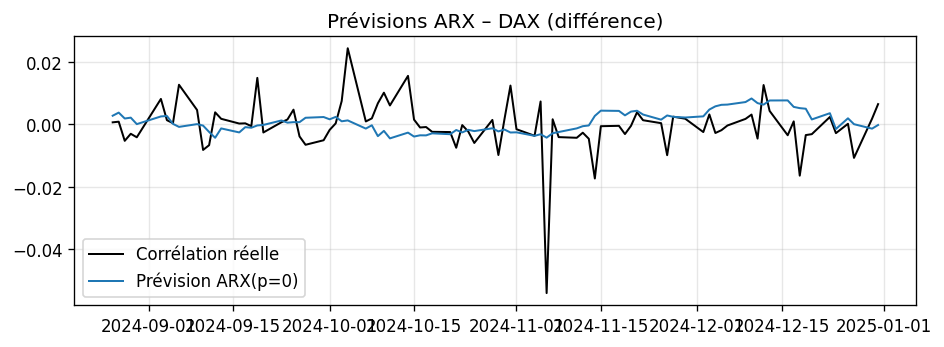

/var/folders/bx/rtwm1h_55kq4g_m48zp38fnm0000gp/T/ipykernel_96848/4214429910.py:45: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  preds.append(float(model.predict(x_t)))
/var/folders/bx/rtwm1h_55kq4g_m48zp38fnm0000gp/T/ipykernel_96848/4214429910.py:45: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  preds.append(float(model.predict(x_t)))
/var/folders/bx/rtwm1h_55kq4g_m48zp38fnm0000gp/T/ipykernel_96848/4214429910.py:45: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  preds.append(float(model.predict(x_t)))
/var/folders/bx/rtwm1h_55kq4g_m48zp38fnm0000gp/T/ipykernel_96848/4214429910.py:45: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. U

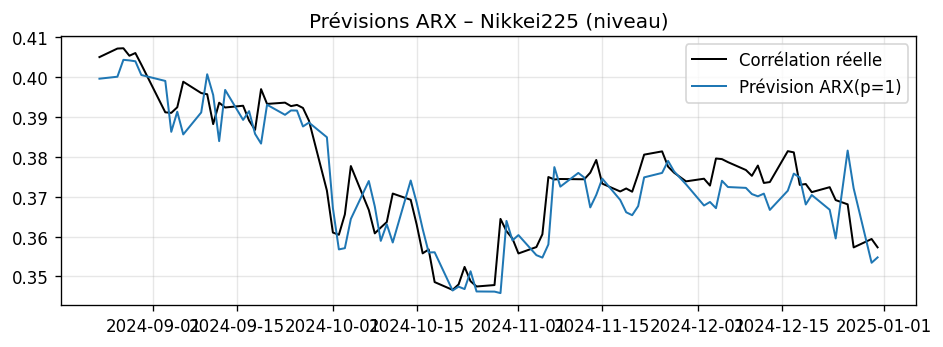

/var/folders/bx/rtwm1h_55kq4g_m48zp38fnm0000gp/T/ipykernel_96848/4214429910.py:45: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  preds.append(float(model.predict(x_t)))
/var/folders/bx/rtwm1h_55kq4g_m48zp38fnm0000gp/T/ipykernel_96848/4214429910.py:45: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  preds.append(float(model.predict(x_t)))
/var/folders/bx/rtwm1h_55kq4g_m48zp38fnm0000gp/T/ipykernel_96848/4214429910.py:45: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  preds.append(float(model.predict(x_t)))
/var/folders/bx/rtwm1h_55kq4g_m48zp38fnm0000gp/T/ipykernel_96848/4214429910.py:45: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. U

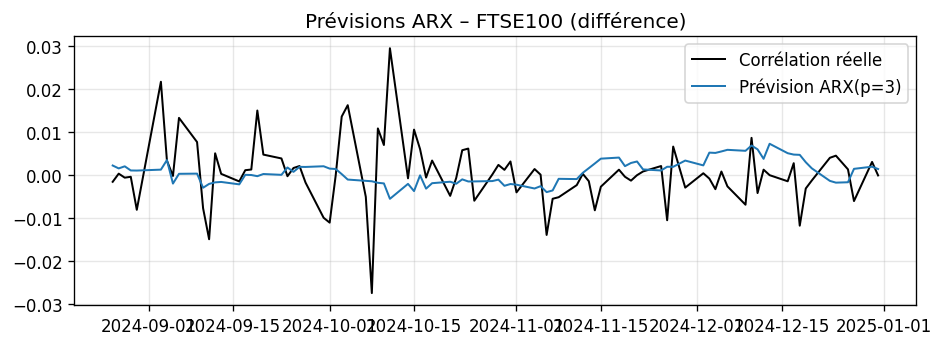

/var/folders/bx/rtwm1h_55kq4g_m48zp38fnm0000gp/T/ipykernel_96848/4214429910.py:45: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  preds.append(float(model.predict(x_t)))
/var/folders/bx/rtwm1h_55kq4g_m48zp38fnm0000gp/T/ipykernel_96848/4214429910.py:45: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  preds.append(float(model.predict(x_t)))
/var/folders/bx/rtwm1h_55kq4g_m48zp38fnm0000gp/T/ipykernel_96848/4214429910.py:45: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  preds.append(float(model.predict(x_t)))
/var/folders/bx/rtwm1h_55kq4g_m48zp38fnm0000gp/T/ipykernel_96848/4214429910.py:45: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. U

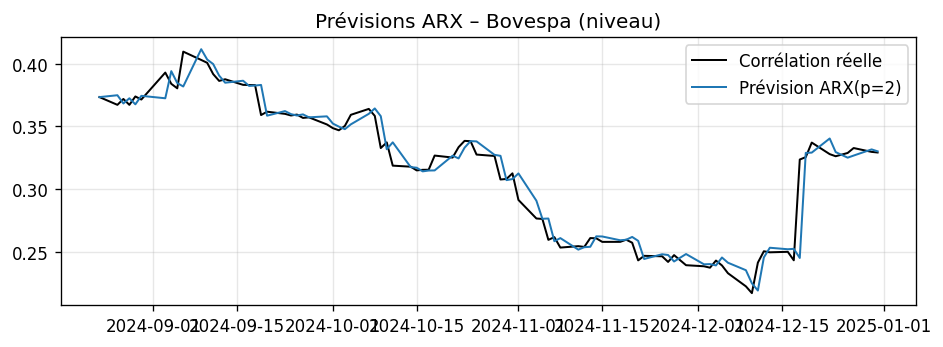

/var/folders/bx/rtwm1h_55kq4g_m48zp38fnm0000gp/T/ipykernel_96848/4214429910.py:45: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  preds.append(float(model.predict(x_t)))
/var/folders/bx/rtwm1h_55kq4g_m48zp38fnm0000gp/T/ipykernel_96848/4214429910.py:45: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  preds.append(float(model.predict(x_t)))
/var/folders/bx/rtwm1h_55kq4g_m48zp38fnm0000gp/T/ipykernel_96848/4214429910.py:45: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  preds.append(float(model.predict(x_t)))
/var/folders/bx/rtwm1h_55kq4g_m48zp38fnm0000gp/T/ipykernel_96848/4214429910.py:45: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. U

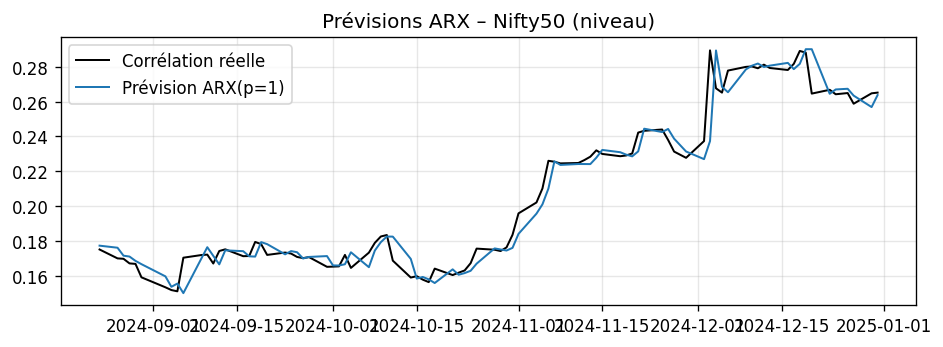

In [231]:
# === Étape 3 : Estimer les modèles ARX selon le type ===
results_arx = []
for col in markets:
    y_raw = df[col].astype(float)

    # Appliquer la transformation correcte
    if model_type[col] == "différence":
        y = y_raw.diff().dropna()
    else:
        y = y_raw

    p_sel = p_values[col]
    y_true, y_hat, rmse = forecast_oos(y, Xexog_full, H=H, p=p_sel, L=L)
    results_arx.append({"Série": col.replace("corr_SP500_", ""), "p": p_sel, "RMSE_ARX": rmse})

    # Graphique individuel
    plt.figure(figsize=(8, 3))
    plt.plot(y_true.index, y_true, color="black", lw=1.2, label="Corrélation réelle")
    plt.plot(y_hat.index, y_hat, color="tab:blue", lw=1.2, label=f"Prévision ARX(p={p_sel})")
    plt.title(f"Prévisions ARX – {col.replace('corr_SP500_', '')} ({model_type[col]})")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()



In [233]:
# === Étape 4 : Comparaison AR (2.2) vs ARX (2.4) ===
results_comparison = []
for r in results_arx:
    name = "corr_SP500_" + r["Série"]
    rmse_ar = rmse_ar_section2_2[name]
    rmse_arx = r["RMSE_ARX"]
    gain = (1 - rmse_arx / rmse_ar) * 100
    results_comparison.append({
        "Série": r["Série"],
        "Type": model_type[name],
        "p": r["p"],
        "RMSE_AR": rmse_ar,
        "RMSE_ARX": rmse_arx,
        "Gain_%": gain
    })

results_df = pd.DataFrame(results_comparison).set_index("Série").round(4)
print("\n=== Tableau final – Comparaison AR (2.2) vs ARX (2.4) ===\n")
print(results_df)


=== Tableau final – Comparaison AR (2.2) vs ARX (2.4) ===

                 Type  p  RMSE_AR  RMSE_ARX   Gain_%
Série                                               
DAX        différence  0   0.0084    0.0090  -6.6772
Nikkei225      niveau  1   0.0310    0.0067  78.5354
FTSE100    différence  3   0.0075    0.0084 -11.4091
Bovespa        niveau  2   0.0678    0.0121  82.2199
Nifty50        niveau  1   0.0531    0.0087  83.6744
